In [2]:
#save model to HuggingFace hub
#https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/mixtral-8x7b-for-web-qa.ipynb

In [3]:
# Helpful links

# https://docs.haystack.deepset.ai/docs/custom-components
# https://docs.haystack.deepset.ai/docs/promptbuilder
# https://github.com/deepset-ai/haystack/blob/main/examples/retrievers/in_memory_bm25_documentsearch.py
# https://github.com/deepset-ai/haystack-tutorials/tree/main/tutorials

In [4]:
import requests
import json
import os
import torch
import glob
import fnmatch
import pandas as pd
import markdown
from html import unescape
from bs4 import BeautifulSoup
import secrets
from haystack import Document, Pipeline
from IPython.display import display, Image

/home/ubuntu/data/miniconda3/envs/finetune-gllm-sp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [82]:
# Collect from GTN

docs = []
directory_path = "../gtn-data/"

def read_md_file_1(path):
    with open(path) as f:
        content = f.read()
        return content

def read_md_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        md_content = file.read()
    return extract_plain_text_from_md(md_content)

def extract_plain_text_from_md(md_content):
    html_content = markdown.markdown(md_content)
    plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))
    return plain_text.strip()

def generate_hex_id(length):
    random_bytes = secrets.token_bytes(length // 2)
    return random_bytes.hex()
    
#included_content = "/topics/statistics/tutorials/intro_deep_learning/"

included_content = "/topics/"

for root, dirs, files in os.walk(directory_path):
    for filename in files:
        if fnmatch.fnmatch(filename, '*.md'):
            path = os.path.join(root, filename)
            if included_content in path:
                s_path = path.split("/")[-3:]
                tutorial_name = "_".join(s_path)
                md_plain_text = read_md_file(path)
                doc = Document(content=md_plain_text, id=generate_hex_id(10))
                docs.append(doc)

/tmp/ipykernel_101107/3275885192.py:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  plain_text = ''.join(BeautifulSoup(html_content, "html.parser").findAll(text=True))


In [83]:
len(docs)

1390

In [84]:
# Collect from PRs
# process PRs
for json_file in glob.glob("../out/github_pr_page_*.json"):
    with open(json_file, "r") as fin:
        doc_json = json.load(fin)
        for pr in doc_json:
            pr_text = pr["body"]
            if pr_text != None:
                useful_text_limit = pr_text.find("## How to test the changes")
                if useful_text_limit > 0:
                    pr_text = pr_text[:useful_text_limit].strip()
                    doc = Document(content=pr_text, id=generate_hex_id(10))
                    docs.append(doc)

In [85]:
import random
random.shuffle(docs)

In [86]:
len(docs), docs[:5]

(5044,
 [Document(id=3ddf1ef8f1, content: '(Please replace this header with a description of your pull request. Please include *BOTH* what you ...'),
  Document(id=18287d41f3, content: '## What did you do? 
  - Fix SQLAlchemy queries in jobs API
  - Fix resulting mypy issues by initialis...'),
  Document(id=af5e730c37, content: 'Fixes part of https://help.galaxyproject.org/t/workflow-documentation-via-link/10927/3.
  
  The other...'),
  Document(id=d5c162f724, content: '## What did you do? 
  - Added a bunch of tests for testing the `sharing` API functionality with the ...'),
  Document(id=508a114dbd, content: 'That's just doing what the other job handlers are doing, and it avoids
  
  ```
  Could not find import...')])

In [87]:
raw_documents = docs[:500]
len(raw_documents)

500

In [88]:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.utils import ComponentDevice
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder

document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

In [89]:
# https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/zephyr-7b-beta-for-rag.ipynb
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=2))
indexing.add_component("doc_embedder", SentenceTransformersDocumentEmbedder(model="thenlper/gte-large",
                                                                            device=ComponentDevice.from_str("cuda:0"), 
                                                                            meta_fields_to_embed=["title"]))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "doc_embedder")
indexing.connect("doc_embedder", "writer")

🚅 Components
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - cleaner.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])
  - doc_embedder.documents -> writer.documents (List[Document])

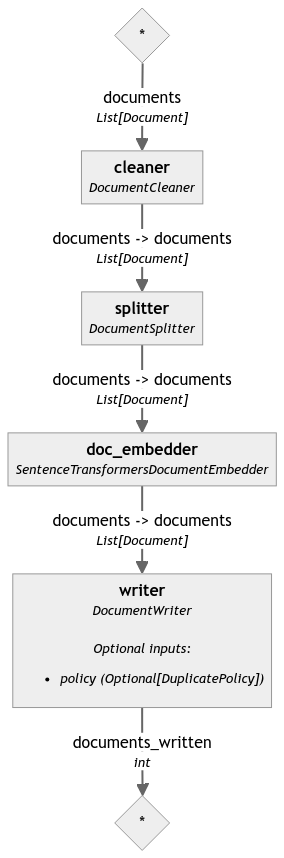

In [90]:
indexing.draw("indexing.png")
Image(filename='indexing.png')

In [91]:
indexing.run({"cleaner":{"documents":raw_documents}})

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:35<00:00,  6.53it/s]


{'writer': {'documents_written': 7312}}

In [92]:
pprint(document_store.filter_documents()[0])

Document(id=d40ab8d681c733d33829d7e4dbff2ef25df615fbfa3e801af05d616b206c5059, content: '## What did you do? - Fix SQLAlchemy queries in jobs API - Fix resulting mypy issues by initialising...', meta: {'source_id': '34ed582e5629257a3f9c213abcf17e29450b301f7775f4a0ce09663e889d5948', 'page_number': 1}, embedding: vector of size 1024)


In [93]:
print(len(document_store.filter_documents()[0].embedding))

1024


In [94]:
prompt_template = """
    Given these documents, answer the question.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

prompt_builder = PromptBuilder(template=prompt_template)

In [95]:
from haystack.components.generators import HuggingFaceTGIGenerator, HuggingFaceLocalGenerator
from haystack.utils import Secret

model_kwargs = {
    "load_in_4bit":True,
    "bnb_4bit_use_double_quant":True,
    "bnb_4bit_quant_type":"nf4",
    "bnb_4bit_compute_dtype":torch.bfloat16
}

generator = HuggingFaceLocalGenerator(
    "HuggingFaceH4/zephyr-7b-beta", 
    huggingface_pipeline_kwargs={"device_map":"auto",
    "model_kwargs": model_kwargs},
    generation_kwargs={"max_new_tokens": 350}
)
generator.warm_up()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.26s/it]


In [96]:
rag = Pipeline()
rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model="thenlper/gte-large", 
                                                                    device=ComponentDevice.from_str("cuda:0")))
rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=5))
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", generator)

In [97]:
rag.connect("text_embedder", "retriever")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm.prompt")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: HuggingFaceLocalGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

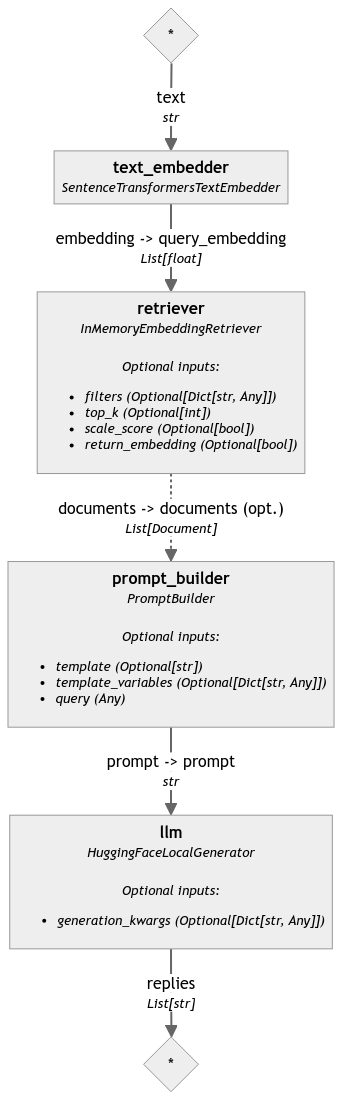

In [98]:
rag.draw("rag.png")
display(Image(filename='rag.png'))

In [99]:
query = "I would suggest installing the refseq_masher package. I checked earlier, and found it in the toolshed. \
Please, this package will help a lot."

results = rag.run({
        "text_embedder": {"text": query},
        "prompt_builder": {"query": query}
    }
)

answer = results["llm"]["replies"][0]

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.83it/s]


In [100]:
from pprint import pprint

print(answer)

 To install the refseq_masher package, follow these steps:

1. Go to the Galaxy main page (https://usegalaxy.org/) and log in to your account.
2. Click on the "Tools" tab in the top menu bar.
3. In the "Toolshed" section, click on "Manage & Install Tools".
4. In the "Manage & Install Tools" page, search for "refseq_masher" in the search bar.
5. Click on the "refseq_masher" package to view its details.
6. Click on the "Install" button to install the package.
7. Follow the prompts to complete the installation process.
8. Once the installation is complete, you can access the refseq_masher package in your Galaxy workspace.

The refseq_masher package will provide you with a set of tools for working with reference genomes, including functions for aligning reads to a reference genome, calling variants, and generating genome statistics. This package will be a valuable resource for your analysis, and I recommend exploring its documentation and tutorials to learn more about its capabilities.

I 